# Model Configuration - 42 School Pass/Fail Prediction






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import requests
import json
import csv
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA

## 0. Collecting data and Merge Data

### 0-1. Calling API

Please refer to the "Calling API Repository"

By calling /v2/campus/:/campus_id/users, we could separately collect raw data for all users of Seoul 42 Campus and Ecole 42 Campus, and the campus_ids for each are 29 and 1.

By calling /v2/users/:user_id/scale_teams/as_corrector and /v2/users/:user_id/scale_teams/as_corrected, 
we were able to obtain data in json format with items for events in which a user participated as a correcter and correction recipient.

By counting item named with corrcected, we've figured out how many evaluations they gave (corrector) and feedback they received(corrected).

### 0-2. Crawling

Please refer to the "Crawling Repository"

We collected 'PASS, Highest C Piscine, Final exam score, Number of group assignments, level, penalty' 

Data is collected through crawling by accessing each user's page.

Level: Overall progress that can be made through assignments, and midterm exams

Group Assignments: Optional group assignments

Penalty: How many times you cheated; each time a user get caught, 42 points will be deducted from assignment score

Highest C-picsine: In assignments using the C language, the highest level of assignment completed (0~13)

Final Exam Score: as it is.

## 1. Preprocessing
### 1-1. Load the data

In [2]:
data = pd.read_csv('/Users/kimkangmin/data_set_42seoul.csv')
data

,correcteds,correctors,created_at,PASS,Highest C Piscine,Final exam score,Number of group assignments,level,penalty
0,2,6,10,0,0,NaN,0,0.00,0
1,14,0,10,0,0,NaN,0,0.00,0
2,2,7,10,0,0,NaN,1,1.19,0
3,40,26,10,0,4,NaN,3,5.34,0
4,0,0,10,0,0,NaN,0,0.00,0
...,...,...,...,...,...,...,...,...,...
4318,92,96,2,1,11,66.0,3,9.84,0
4319,56,66,2,1,9,66.0,4,7.92,0
4320,67,80,2,1,9,54.0,3,8.85,0
4321,103,120,2,1,11,100.0,4,12.94,0


### 1-2. drop the data points whose final exam score is under 42.

In [3]:
data = data[data['Final exam score'] >= 42]
data.shape

(2911, 9)

### 1-3. checking the VIF

In [4]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

In [5]:
features_for_vif = data.drop('PASS', axis=1).select_dtypes(include=['float', 'int'])

# Calculate VIF
vif_result = calculate_vif(features_for_vif)

# Display VIF results
print("VIF Results:")
print(vif_result)

VIF Results:
                       Feature        VIF
0                   correcteds  22.603433
1                   correctors  29.333567
2                   created_at   8.581801
3            Highest C Piscine  49.141438
4             Final exam score  36.154867
5  Number of group assignments  14.160705
6                        level  59.255415
7                      penalty   1.008364


### Dropping 'level'

There is high VIF in the 'level'.

1. Redundancy:
The 'level' feature is a sum of assignments and tests.
Including both the individual assignments/tests and their sum ('level') in the model may introduce redundancy.

2. Interpretability:
one of the primary goal is to understand the impact of individual assignments and tests on the outcome.
So, having both the components and the sum might complicate the interpretation of the model.

For the following reasons, we decided to remove the level attribute.

In [6]:
data = data.drop('level', axis=1)

# Calculate VIF
vif_result = calculate_vif(features_for_vif)

# Display VIF results
print("VIF Results:")
print(vif_result)

VIF Results:
                       Feature        VIF
0                   correcteds  22.603433
1                   correctors  29.333567
2                   created_at   8.581801
3            Highest C Piscine  49.141438
4             Final exam score  36.154867
5  Number of group assignments  14.160705
6                        level  59.255415
7                      penalty   1.008364


### Reforming 'correcteds and correctors'

There is high VIF in the 'correcteds and correctors'.

이거는 서로 큰 상관관계가 있을 것이라고 예측되고, 우리의 목표는 피어 리뷰가 중요한지이기 때문에'correcteds and correctors'를 합쳐서 peer review라는 새로운 컬럼을 만들겠다.

In [7]:
data['peer_reviews'] = data['correcteds'] + data['correctors']

#Drop 'corrected' and 'correctors'
data = data.drop(['correcteds', 'correctors'], axis=1)


# Calculate VIF
vif_result = calculate_vif(features_for_vif)

# Display VIF results
print("VIF Results:")
print(vif_result)

VIF Results:
                       Feature        VIF
0                   correcteds  22.603433
1                   correctors  29.333567
2                   created_at   8.581801
3            Highest C Piscine  49.141438
4             Final exam score  36.154867
5  Number of group assignments  14.160705
6                        level  59.255415
7                      penalty   1.008364


In [8]:
# Drop 'corrected' and 'correctors'
data = data.drop(['Highest C Piscine'], axis=1)

features_for_vif = data.drop('PASS', axis=1).select_dtypes(include=['float', 'int'])

# Calculate VIF
vif_result = calculate_vif(features_for_vif)

# Display VIF results
print("VIF Results:")
print(vif_result)

VIF Results:
                       Feature        VIF
0                   created_at   6.973460
1             Final exam score  20.177422
2  Number of group assignments  12.998627
3                      penalty   1.006309
4                 peer_reviews   6.479997


### 1-3. EDA

### Pair Plot

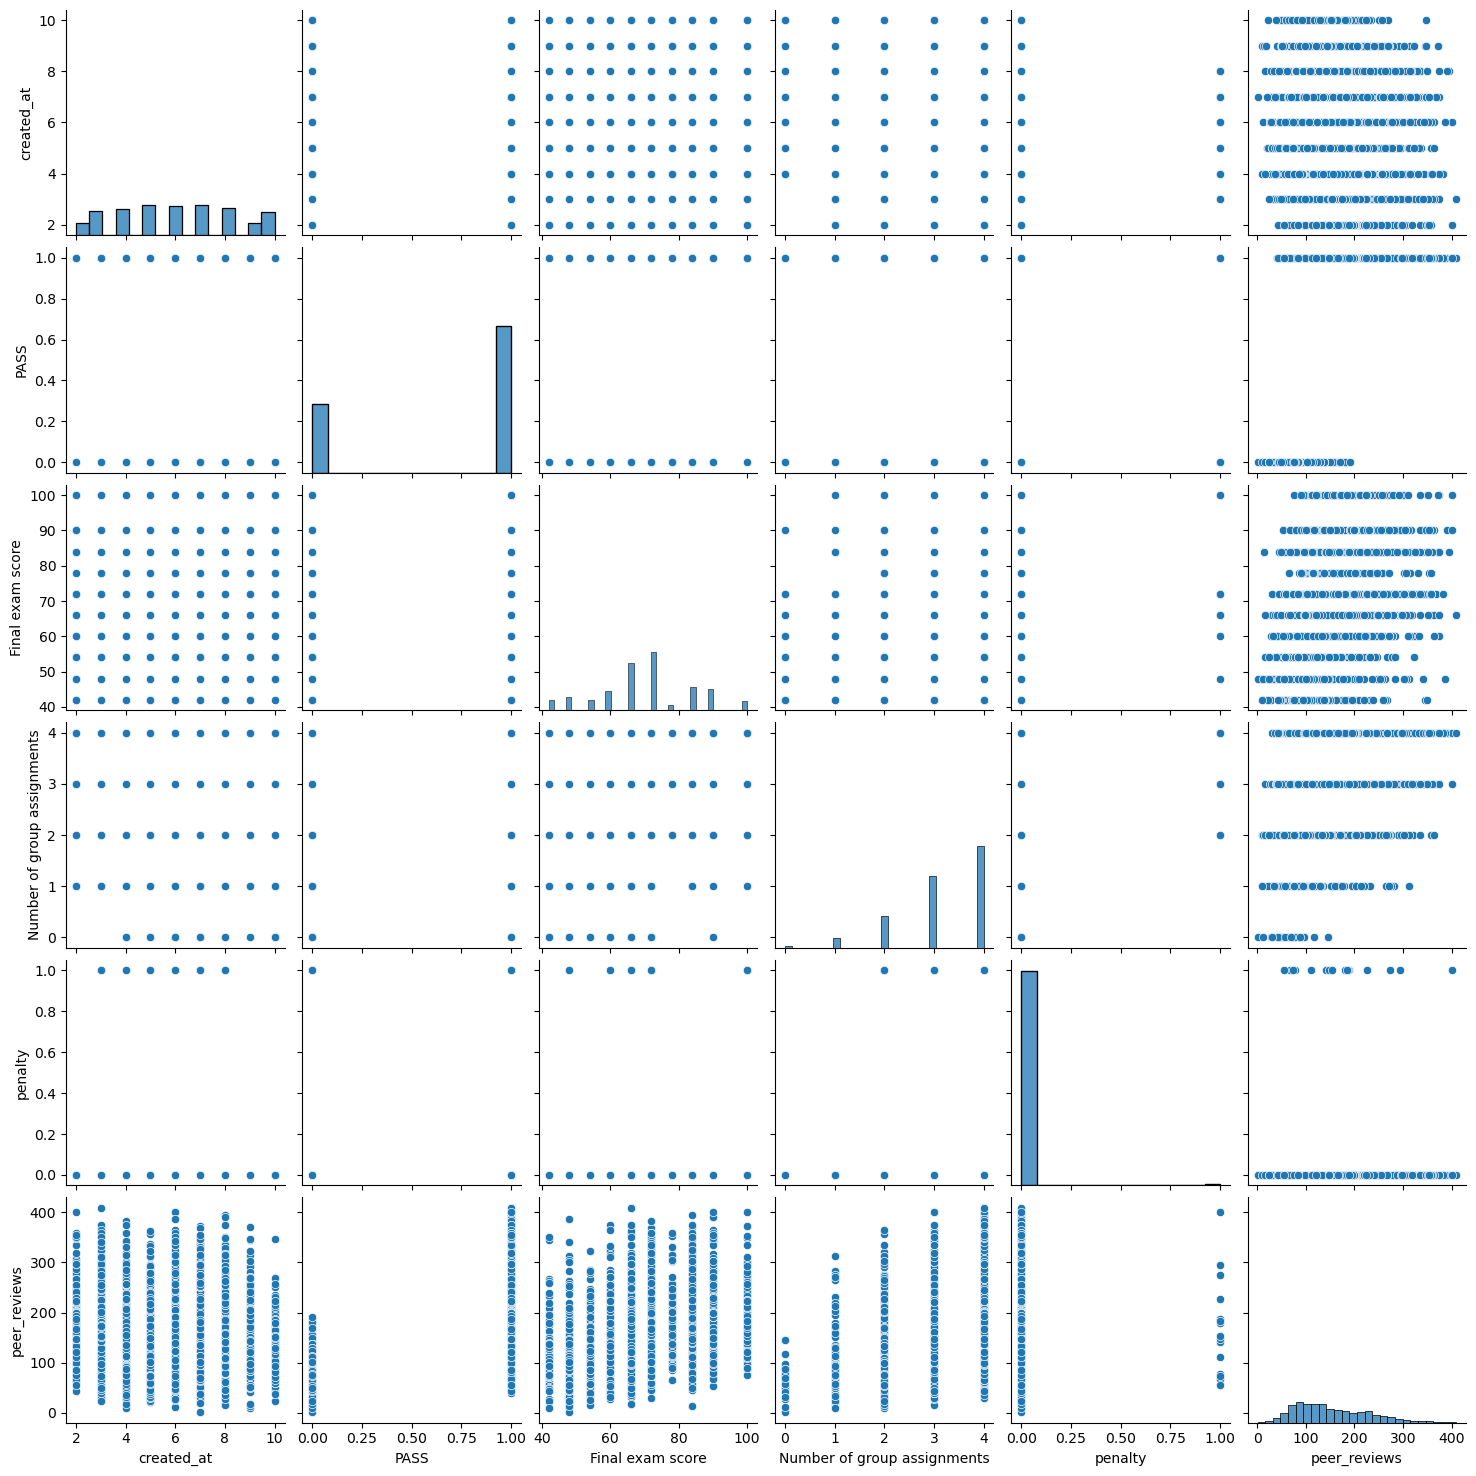

In [9]:
import seaborn as sns
sns.pairplot(data)
plt.show()

### Correlation Matrix

NameError: name 'X' is not defined

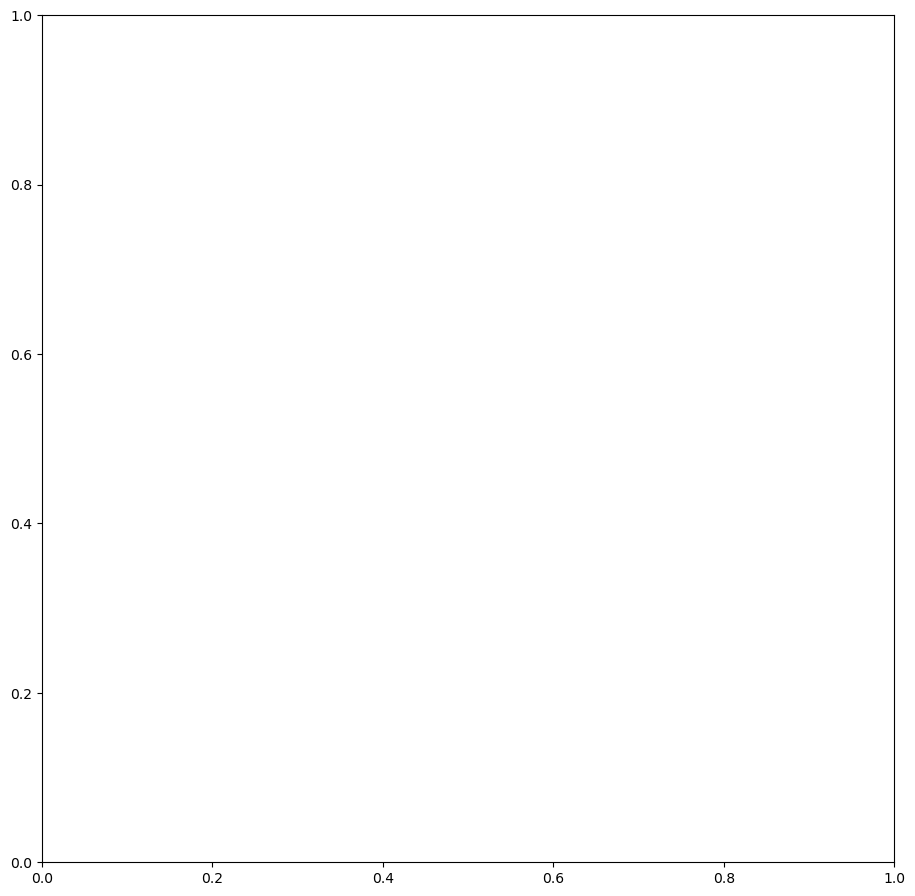

In [10]:
fig, ax = plt.subplots(figsize=(11, 11))
X_corr = X.corr()

# mask
mask = np.triu(np.ones_like(X_corr, dtype=bool))

# adjust mask and df
mask = mask[:, :]
corr = X_corr.iloc[:,:].copy()

# color map (RdBu_r 사용)
cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)

# 또는 다른 색상 맵을 사용할 수도 있습니다
# cmap = 'coolwarm'

# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", 
            linewidths=5, cmap=cmap, vmin=-1, vmax=1, 
            cbar_kws={"shrink": .8}, square=True)

# ticks
yticks = [i.upper() for i in corr.index]
xticks = [i.upper() for i in corr.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks)

# title
title = 'CORRELATION MATRIX\n'
plt.title(title, loc='left', fontsize=15)
plt.show()

### 1-4. Apply one-hot encoding for splitting generation

In [11]:
data_encoded = pd.get_dummies(data['created_at'].astype(str), prefix='generation')

data = pd.concat([data, data_encoded], axis=1)

data = data.drop('created_at', axis=1)

data

,PASS,Final exam score,Number of group assignments,penalty,peer_reviews,generation_10,generation_2,generation_3,generation_4,generation_5,generation_6,generation_7,generation_8,generation_9
5,0,54.0,0,0,146,1,0,0,0,0,0,0,0,0
6,1,72.0,3,0,219,1,0,0,0,0,0,0,0,0
8,0,60.0,3,0,122,1,0,0,0,0,0,0,0,0
13,0,60.0,4,0,73,1,0,0,0,0,0,0,0,0
18,1,66.0,3,0,170,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4318,1,66.0,3,0,188,0,1,0,0,0,0,0,0,0
4319,1,66.0,4,0,122,0,1,0,0,0,0,0,0,0
4320,1,54.0,3,0,147,0,1,0,0,0,0,0,0,0
4321,1,100.0,4,0,223,0,1,0,0,0,0,0,0,0


### 1-5. Split the data into train set and test set

In [12]:
X = data.drop('PASS', axis = 1)
y = data['PASS']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 0)

## 2. Data Mining with Pipeline

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Define the pipeline with imbalanced-learn
pipe = ImbPipeline([
    ('preprocessing', None),
    ('sampler', None),  # Added for oversampling/undersampling
    ('classifier', None)
])
hyperparam_grid = [
    {
        'preprocessing': [None],
        'classifier': [RandomForestClassifier()],
        'classifier__max_features': [1, 2, 3, 4, 5],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30],
        'sampler': [RandomOverSampler(), RandomUnderSampler(), None]
    },{
        'preprocessing': [StandardScaler(), MinMaxScaler(), None],
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [1, 3, 5, 10, 15],
        'classifier__metric': ['minkowski', 'euclidean', 'mahalanobis'],
        'sampler': [RandomOverSampler(), RandomUnderSampler(), None]
    }
]

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid_search = GridSearchCV(pipe, hyperparam_grid, scoring='roc_auc', refit=True, cv=kfold)
grid_search.fit(X_train, y_train)

print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best Training score: {grid_search.best_score_}")
print(f"Test-set score: {grid_search.score(X_test, y_test)}")

Best hyperparameters: {'classifier': RandomForestClassifier(criterion='entropy', max_depth=10, max_features=4), 'classifier__criterion': 'entropy', 'classifier__max_depth': 10, 'classifier__max_features': 4, 'classifier__n_estimators': 100, 'preprocessing': None, 'sampler': None}
Best Training score: 0.9706304723583645
Test-set score: 0.9779543761007993


/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
225 fits failed out of a total of 2475.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
225 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/Users/kimkangmin/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.

In [16]:
best_classifier = grid_search.best_estimator_.named_steps['classifier']

if isinstance(best_classifier, LogisticRegression):
    # For Logistic Regression, retrieve coefficients as feature importances
    coefficients = best_classifier.coef_[0]
    feature_importances = abs(coefficients)  # Use absolute values for importance
    feature_names = X_train.columns  # Assuming X_train is a DataFrame
    importance_dict = dict(zip(feature_names, feature_importances))
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    print("Feature Importances (Logistic Regression):")
    for feature, importance in sorted_importance:
        print(f"{feature}: {importance}")

elif isinstance(best_classifier, RandomForestClassifier) or isinstance(best_classifier, KNeighborsClassifier):
    # Fit the best model from grid search on the entire training data
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = best_model.named_steps['classifier'].feature_importances_

    # Create a DataFrame to display feature importances
    importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

    # Sort the DataFrame by importance in descending order
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Print the feature importances
    print("Feature Importances:")
    print(importance_df)

Feature Importances:
                        Feature  Importance
3                  peer_reviews    0.570372
0              Final exam score    0.196190
1   Number of group assignments    0.058713
6                  generation_3    0.050036
5                  generation_2    0.036864
8                  generation_5    0.024939
12                 generation_9    0.017248
11                 generation_8    0.014334
4                 generation_10    0.008711
10                 generation_7    0.008480
7                  generation_4    0.006488
9                  generation_6    0.005894
2                       penalty    0.001731


## 3. Post-Processing

### 3-1. ROC Curve

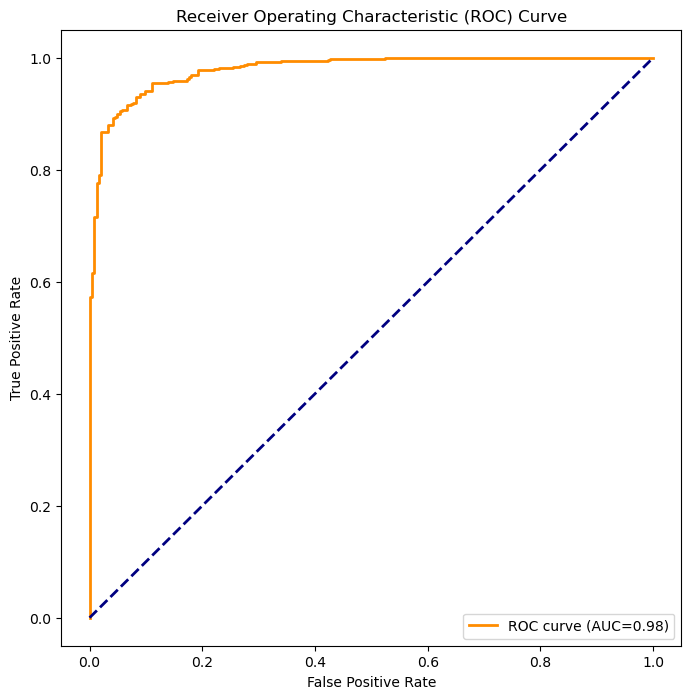

In [17]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 최적 모델 예측 확률 구하기
y_prob = grid_search.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# AUC(Area Under the Curve) 계산
roc_auc = auc(fpr, tpr)

# ROC 커브 그리기
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC={roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


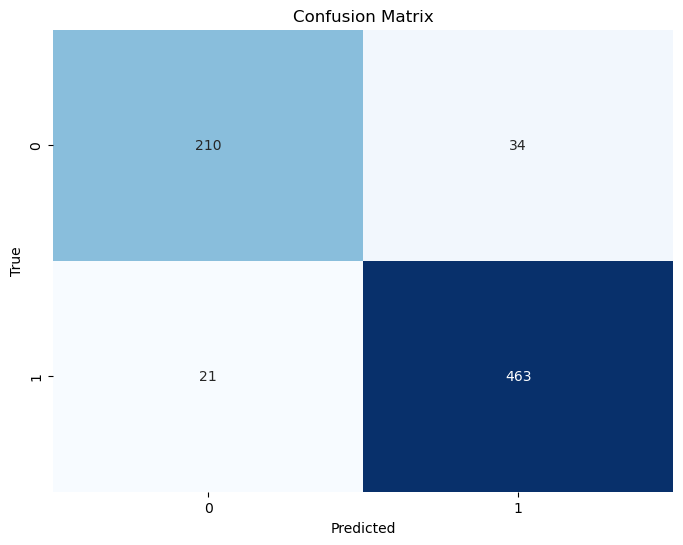

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()